### Importing required libraries

In [1]:
import cv2
import svm
import numpy as np
import math as m
import sys
from scipy.special import gamma as tgamma
import os

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report,confusion_matrix, f1_score
from sklearn.model_selection import train_test_split

import pandas as pd    

from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
import xgboost
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
# from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score

In [3]:
def AGGDfit(structdis):
    # variables to count positive pixels / negative pixels and their squared sum
    poscount = 0
    negcount = 0
    possqsum = 0
    negsqsum = 0
    abssum   = 0

    poscount = len(structdis[structdis > 0]) # number of positive pixels
    negcount = len(structdis[structdis < 0]) # number of negative pixels
    
    # calculate squared sum of positive pixels and negative pixels
    possqsum = np.sum(np.power(structdis[structdis > 0], 2))
    negsqsum = np.sum(np.power(structdis[structdis < 0], 2))
    
    # absolute squared sum
    abssum = np.sum(structdis[structdis > 0]) + np.sum(-1 * structdis[structdis < 0])

    # calculate left sigma variance and right sigma variance
    lsigma_best = np.sqrt((negsqsum/negcount))
    rsigma_best = np.sqrt((possqsum/poscount))

    gammahat = lsigma_best/rsigma_best
    
    # total number of pixels - totalcount
    totalcount = structdis.shape[1] * structdis.shape[0]

    rhat = m.pow(abssum/totalcount, 2)/((negsqsum + possqsum)/totalcount)
    rhatnorm = rhat * (m.pow(gammahat, 3) + 1) * (gammahat + 1)/(m.pow(m.pow(gammahat, 2) + 1, 2))
    
    prevgamma = 0
    prevdiff  = 1e10
    sampling  = 0.001
    gam = 0.2

    # vectorized function call for best fitting parameters
    vectfunc = np.vectorize(func, otypes = [np.float], cache = False)
    
    # calculate best fit params
    gamma_best = vectfunc(gam, prevgamma, prevdiff, sampling, rhatnorm)

    return [lsigma_best, rsigma_best, gamma_best] 

def func(gam, prevgamma, prevdiff, sampling, rhatnorm):
    while(gam < 10):
        r_gam = tgamma(2/gam) * tgamma(2/gam) / (tgamma(1/gam) * tgamma(3/gam))
        diff = abs(r_gam - rhatnorm)
        if(diff > prevdiff): break
        prevdiff = diff
        prevgamma = gam
        gam += sampling
    gamma_best = prevgamma
    return gamma_best

#function to create features
def compute_features(img):
    scalenum = 2
    feat = []
    # make a copy of the image 
    im_original = img.copy()

    # scale the images twice 
    for itr_scale in range(scalenum):
        im = im_original.copy()
        # normalize the image
        im = im / 255.0

        # calculating MSCN coefficients
        mu = cv2.GaussianBlur(im, (7, 7), 1.166)
        mu_sq = mu * mu
        sigma = cv2.GaussianBlur(im*im, (7, 7), 1.166)
        sigma = (sigma - mu_sq)**0.5
        
        # structdis is the MSCN image
        structdis = im - mu
        structdis /= (sigma + 1.0/255)
    
        # calculate best fitted parameters from MSCN image
        best_fit_params = AGGDfit(structdis)
        # unwrap the best fit parameters 
        lsigma_best = best_fit_params[0]
        rsigma_best = best_fit_params[1]
        gamma_best  = best_fit_params[2]
        
        # append the best fit parameters for MSCN image
        feat.append(gamma_best)
        feat.append((lsigma_best*lsigma_best + rsigma_best*rsigma_best)/2)

        # shifting indices for creating pair-wise products
        shifts = [[0,1], [1,0], [1,1], [-1,1]] # H V D1 D2

        for itr_shift in range(1, len(shifts) + 1):
            OrigArr = structdis
            reqshift = shifts[itr_shift-1] # shifting index

            # create transformation matrix for warpAffine function
            M = np.float32([[1, 0, reqshift[1]], [0, 1, reqshift[0]]])
            ShiftArr = cv2.warpAffine(OrigArr, M, (structdis.shape[1], structdis.shape[0]))
            
            Shifted_new_structdis = ShiftArr
            Shifted_new_structdis = Shifted_new_structdis * structdis
            # shifted_new_structdis is the pairwise product 
            # best fit the pairwise product 
            best_fit_params = AGGDfit(Shifted_new_structdis)
            lsigma_best = best_fit_params[0]
            rsigma_best = best_fit_params[1]
            gamma_best  = best_fit_params[2]

            constant = m.pow(tgamma(1/gamma_best), 0.5)/m.pow(tgamma(3/gamma_best), 0.5)
            meanparam = (rsigma_best - lsigma_best) * (tgamma(2/gamma_best)/tgamma(1/gamma_best)) * constant

            # append the best fit calculated parameters            
            feat.append(gamma_best) # gamma best
            feat.append(meanparam) # mean shape
            feat.append(m.pow(lsigma_best, 2)) # left variance square
            feat.append(m.pow(rsigma_best, 2)) # right variance square
        
        # resize the image on next iteration
        im_original = cv2.resize(im_original, (0,0), fx=0.5, fy=0.5, interpolation=cv2.INTER_CUBIC)
    return feat

In [7]:
# function to create features and scale them
# takes input of the image path
def test_measure_BRISQUE(imgPath):
    # read image from given path
    dis = cv2.imread(imgPath, 1)
    if(dis is None):
        print("Wrong image path given")
        print("Exiting...")
        sys.exit(0)
    # convert to gray scale
    dis = cv2.cvtColor(dis, cv2.COLOR_BGR2GRAY)

    # compute feature vectors of the image
    features = compute_features(dis)
    # rescale the brisqueFeatures vector from -1 to 1
    x=[0]
    
    # pre loaded lists from Module to rescale brisquefeatures vector to [-1, 1]
    min_= [0.336999 ,0.019667 ,0.230000 ,-0.125959 ,0.000167 ,0.000616 ,0.231000 ,-0.125873 ,0.000165 ,0.000600 ,0.241000 ,-0.128814 ,0.000179 ,0.000386 ,0.243000 ,-0.133080 ,0.000182 ,0.000421 ,0.436998 ,0.016929 ,0.247000 ,-0.200231 ,0.000104 ,0.000834 ,0.257000 ,-0.200017 ,0.000112 ,0.000876 ,0.257000 ,-0.155072 ,0.000112 ,0.000356 ,0.258000 ,-0.154374 ,0.000117 ,0.000351]
    
    max_= [9.999411, 0.807472, 1.644021, 0.202917, 0.712384, 0.468672, 1.644021, 0.169548, 0.713132, 0.467896, 1.553016, 0.101368, 0.687324, 0.533087, 1.554016, 0.101000, 0.689177, 0.533133, 3.639918, 0.800955, 1.096995, 0.175286, 0.755547, 0.399270, 1.095995, 0.155928, 0.751488, 0.402398, 1.041992, 0.093209, 0.623516, 0.532925, 1.042992, 0.093714, 0.621958, 0.534484]
    
    # append the rescaled vector to x 
    for i in range(0, 36):
        min = min_[i]
        max = max_[i] 
        x.append(-1 + (2.0/(max - min) * (features[i] - min)))
          
    return x

In [8]:
# listing names of bad quality & good quality images
bq = os.listdir(r'E:\Downloads\iqa_assignment\bad_quality')
gq = os.listdir(r'E:\Downloads\iqa_assignment\good_quality')

In [9]:
#reading good quality images & creating features for them in a df 

#dataframe with good quality images
df_gq = pd.DataFrame(columns=np.arange(0,37))

#dataframe with bad quality images
df_bq = pd.DataFrame(columns=np.arange(0,37))

def creating_df(df_name, list_name, path):
    count=0
    for i in list_name:
        df_name.loc[count]=test_measure_BRISQUE(path+"//"+i) 
        count=count+1
        
    return(df_name)
        
df_gq= creating_df(df_gq, gq, path='good_quality')
df_bq= creating_df(df_bq, bq, path='bad_quality')

C:\Users\Nidhi\Anaconda3\lib\site-packages\ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in sqrt


In [11]:
#defining target
df_bq['target']=0
df_gq['target']=1
df = pd.concat([df_bq, df_gq], axis=0)
df.drop(0, axis=1, inplace=True)

In [12]:
#train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.drop('target', axis=1), df['target'], test_size=0.3, stratify=df['target'], random_state=1)

### Oversampling

In [15]:
oversample = SMOTE(sampling_strategy=1)
X_train, Y = oversample.fit_resample(x_train, y_train)

C:\Users\Nidhi\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


#### Cross validation

In [44]:

i=0
setused=X_train
targ=Y

scores=[]
accuracy_train=[]
accuracy_test=[]
splits=10
X_test = np.array(x_test)
cnf_matrix=[]
oof_preds = np.zeros((len(X_test)))
kfold, scores = StratifiedKFold(n_splits=splits,random_state=True), list()
for train2, test2 in kfold.split(setused,targ):
    x_train, x_test = setused[train2], setused[test2]
    y_train, y_test = targ[train2], targ[test2]
    eval_set = [(x_test,y_test)]
    #x_train, y_train = oversample.fit_resample(x_train, y_train) 
    model = xgboost.XGBClassifier(random_state=27)

    model.fit(x_train, y_train)
    
    preds = model.predict_proba(x_test)[:, 1]
    
    preds_class = model.predict(x_test)
    preds_class_train = model.predict(x_train)

    accuracy_train.append( round(accuracy_score(y_train, preds_class_train), 2)*100)
    accuracy_test.append( round(accuracy_score(y_test, preds_class), 2)*100)    
    
    oof_preds += model.predict_proba(X_test)[:, 1]
oof_preds = oof_preds/splits

### Result

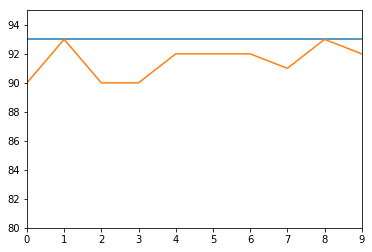

In [49]:
df=pd.DataFrame({'k':np.arange(1,11),
              'accuracy_train':accuracy_train, 
              'accuracy_test' : accuracy_test})
ax=df['accuracy_train'].plot(kind='line')
df['accuracy_test'].plot(kind='line', ax=ax)
plt.ylim(80,95)
plt.show()

In [152]:
result = pd.DataFrame({'accuracy_train' : accuracy_train, 'accuracy_test' : accuracy_test})
result

,accuracy_train,accuracy_test
0,93.0,90.0
1,93.0,93.0
2,93.0,90.0
3,93.0,90.0
4,93.0,92.0
5,93.0,92.0
6,93.0,92.0
7,93.0,91.0
8,93.0,93.0
9,93.0,92.0
